![](dollars_banner.jpg)

# Preface: Welcome to the credit score classifier project! 

**Credit risk assessment** is a vital aspect of financial decision-making that asseses the creditworthiness of individuals or organizations that apply for loands or credit cards.  
Developing this model involved rigorous data preprocessing efforts aimed at cleaning, transforming, and preparing the dataset for analysis. A decent & robust classifier capable of accurately predicting creditworthiness was chosen by leveraging various machine learning models and evaluation metrics.  
This project just goes to show the power of machine learning in its versatile utility in one out of many many fields! 

## Importing Dependencies

In [2]:
# Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# Preprocessing
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer
from sklearn.model_selection import train_test_split
# Classifiers
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
# Evaluation metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


# Part 1: Data Preprocessing

## Task 1.1: Exploration and Initial Feature Selection

Reading the dataset, viewing feature names and data types.

In [3]:
dataset = pd.read_csv('dataset.csv')
print(f'Data shape: {dataset.shape}\n')
print(f'Data features: \n{dataset.dtypes}')

Data shape: (100000, 28)

Data features: 
ID                           object
Customer_ID                  object
Month                        object
Name                         object
Age                          object
SSN                          object
Occupation                   object
Annual_Income                object
Monthly_Inhand_Salary       float64
Num_Bank_Accounts             int64
Num_Credit_Card               int64
Interest_Rate                 int64
Num_of_Loan                  object
Type_of_Loan                 object
Delay_from_due_date           int64
Num_of_Delayed_Payment       object
Changed_Credit_Limit         object
Num_Credit_Inquiries        float64
Credit_Mix                   object
Outstanding_Debt             object
Credit_Utilization_Ratio    float64
Credit_History_Age           object
Payment_of_Min_Amount        object
Total_EMI_per_month         float64
Amount_invested_monthly      object
Payment_Behaviour            object
Monthly_Balance       

C:\Users\LapCell\AppData\Local\Temp\ipykernel_19928\2101642441.py:1: DtypeWarning: Columns (26) have mixed types. Specify dtype option on import or set low_memory=False.
  dataset = pd.read_csv('dataset.csv')


Dropping irrelevent columns. We can just infer by common sense that these features don't affect the credit score.

In [4]:
dataset.drop(columns = ['ID','Customer_ID','Name','SSN','Type_of_Loan'], inplace = True)

## Task 1.2: Cleaning and Transformation

Viewing unique values for each column.

In [5]:
# Function to help in identifying the unique values of a feature and its type to help in feature engineering
def unique_vals_and_type(data: pd.DataFrame, feature: str, cap: int):
  print(f'The unique values of \'{feature}\' feature of type {data[feature].dtype}: {dataset[feature].unique().tolist()[0:cap]}')

for feature in dataset.columns:
  unique_vals_and_type(dataset, feature, 25)

The unique values of 'Month' feature of type object: ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August']
The unique values of 'Age' feature of type object: ['23', '-500', '28_', '28', '34', '54', '55', '21', '31', '33', '34_', '7580', '30', '30_', '24', '24_', '44', '45', '40', '41', '32', '33_', '35', '35_', '36']
The unique values of 'Occupation' feature of type object: ['Scientist', '_______', 'Teacher', 'Engineer', 'Entrepreneur', 'Developer', 'Lawyer', 'Media_Manager', 'Doctor', 'Journalist', 'Manager', 'Accountant', 'Musician', 'Mechanic', 'Writer', 'Architect']
The unique values of 'Annual_Income' feature of type object: ['19114.12', '34847.84', '34847.84_', '143162.64', '30689.89', '30689.89_', '35547.71_', '35547.71', '73928.46', '131313.4', '10909427.0', '34081.38_', '34081.38', '114838.41', '114838.41_', '31370.8', '33751.27', '88640.24', '88640.24_', '54392.16', '54392.16_', '8701.545', '8701.545_', '25546.26', '25546.26_']
The unique values of 'Month

Defining some helper functions to use in analysis and cleaning.

In [6]:
# Removes special characters (underscores) from numeric data while ignoring nan values
def remove_underscores_numeric(data: pd.DataFrame, feature: str, remove_neg: bool = False):
  if data[feature].dtype == 'object':
    data[feature] = pd.to_numeric(data[feature].str.replace('_', ''), errors = 'coerce')
  if remove_neg: 
    data.loc[data[feature] < 0, feature] = np.nan

# Counts outliers which are k standard deviations away from the mean
def count_outliers(data: pd.DataFrame, feature: str, k: int):
  m,s = data[feature].mean() , data[feature].std()
  return np.sum((data[feature] < m - k*s) | (data[feature] > m + k*s))

# Clips outliers which are k standard deviations away from the mean
def clip_outliers(data: pd.DataFrame, feature: str, k: int):
  m,s = data[feature].mean() , data[feature].std()
  data[feature] = data[feature].clip(lower = m - k*s, upper = m + k*s)

Convert numerical features from 'object' type to their orignal type and replacing missing data of each with NA values.

In [7]:
remove_underscores_numeric(dataset, 'Age', remove_neg = True)
remove_underscores_numeric(dataset, 'Num_of_Loan', remove_neg = True)
remove_underscores_numeric(dataset, 'Num_of_Delayed_Payment')
remove_underscores_numeric(dataset, 'Num_Bank_Accounts', remove_neg = True)
remove_underscores_numeric(dataset, 'Annual_Income')
remove_underscores_numeric(dataset, 'Changed_Credit_Limit')
remove_underscores_numeric(dataset, 'Outstanding_Debt')
remove_underscores_numeric(dataset, 'Amount_invested_monthly')
remove_underscores_numeric(dataset, 'Monthly_Balance')
remove_underscores_numeric(dataset, 'Num_of_Delayed_Payment')

Replacing erroneous values in text data with NA values.

In [8]:
dataset['Occupation'] = dataset['Occupation'].replace(to_replace = '_______', value = np.nan)
dataset['Credit_Mix'] = dataset['Credit_Mix'].replace(to_replace = '_', value = np.nan)
dataset['Payment_of_Min_Amount'] = dataset['Payment_of_Min_Amount'].replace(to_replace = 'NM', value = np.nan)
dataset['Payment_Behaviour'] = dataset['Payment_Behaviour'].replace(to_replace = '!@9#%8', value = np.nan)

Extracting data from text columns which have embedded values in a certain form.

In [9]:
# Replace the Credit History Age column with years and months.
temp_df = dataset['Credit_History_Age'].str.extract(r'(?P<Years>[\d]?[\d]) Years and (?P<Months>[\d]?[\d]) Months', expand = True)
dataset['Credit_History_Age'] = temp_df['Years'].astype('float64') + (temp_df['Months'].astype('float64') / 12)

# Split the Payement_Behavior feature into two features which will replace the original feature
temp_df = dataset['Payment_Behaviour'].str.extract(r'(?P<Spending_Behavior>High|Low)_spent_(?P<Payment_Volume>Small|Medium|Large)_value_payments', expand = True)
dataset = pd.concat([dataset.drop(columns = ['Payment_Behaviour']), temp_df], axis = 1)

Checking unique values for each categorical column after cleaning.

In [10]:
# Get which features are of 'object' type in the dataset and their unique values
for feature in dataset.select_dtypes(include = 'object').columns:
  unique_vals_and_type(dataset, feature, 25)

The unique values of 'Month' feature of type object: ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August']
The unique values of 'Occupation' feature of type object: ['Scientist', nan, 'Teacher', 'Engineer', 'Entrepreneur', 'Developer', 'Lawyer', 'Media_Manager', 'Doctor', 'Journalist', 'Manager', 'Accountant', 'Musician', 'Mechanic', 'Writer', 'Architect']
The unique values of 'Credit_Mix' feature of type object: [nan, 'Good', 'Standard', 'Bad']
The unique values of 'Payment_of_Min_Amount' feature of type object: ['No', nan, 'Yes']
The unique values of 'Credit_Score' feature of type object: ['Good', 'Standard', 'Poor']
The unique values of 'Spending_Behavior' feature of type object: ['High', 'Low', nan]
The unique values of 'Payment_Volume' feature of type object: ['Small', 'Large', 'Medium', nan]


To decide whether the occupation and Month columns should be kept, we plot a histogram of occupation - credit score and another one with month - credit score.

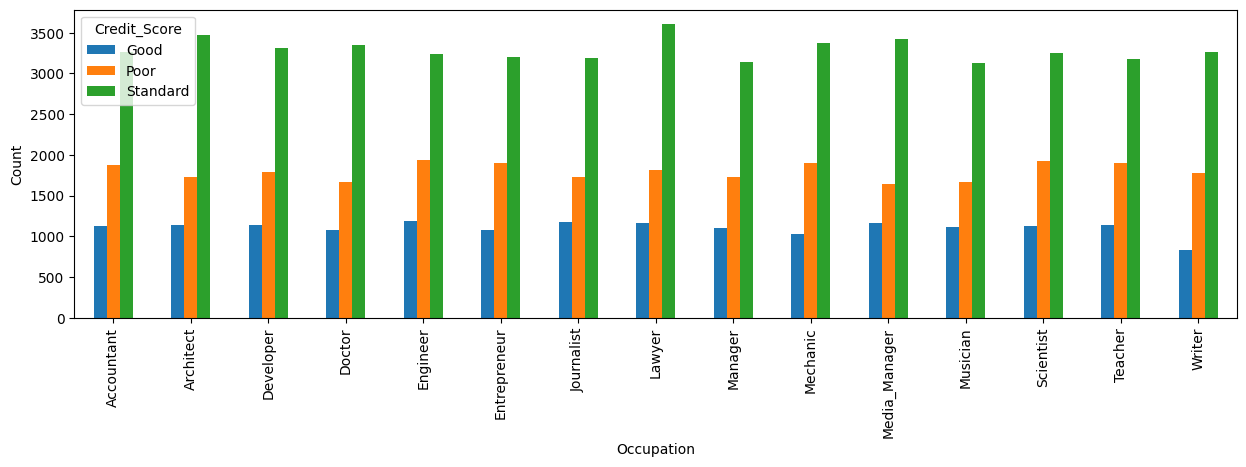

In [11]:
# Plot a cluster column chart of occupation vs credit score
counts = dataset.groupby(['Occupation','Credit_Score'], dropna = True).size().unstack()
counts.plot(kind = 'bar', stacked = False, figsize = (15, 4))
plt.xlabel('Occupation')
plt.ylabel('Count')
plt.legend(title='Credit_Score')
plt.show()

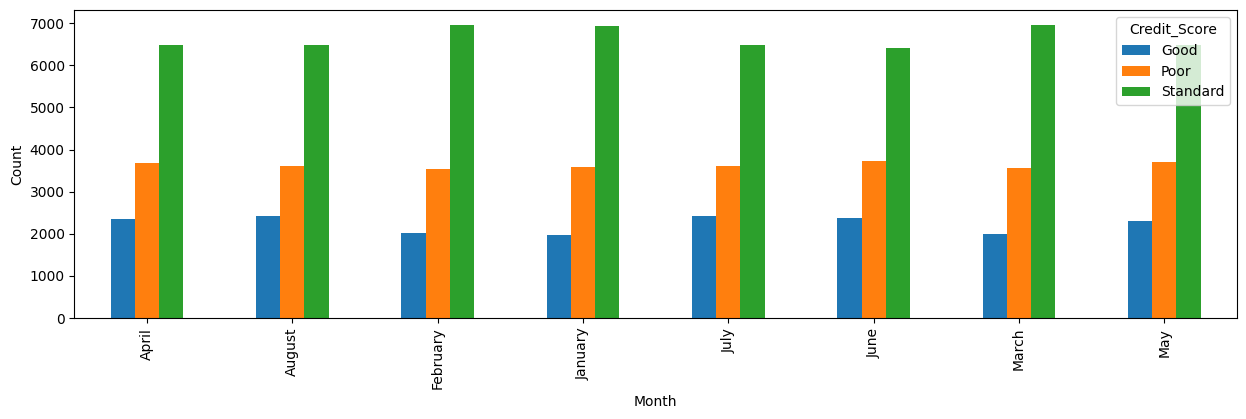

In [12]:
# Plot a cluster column chart of month vs credit score
counts = dataset.groupby(['Month','Credit_Score'], dropna = True).size().unstack()
counts.plot(kind = 'bar', stacked = False, figsize = (15, 4))
plt.xlabel('Month')
plt.ylabel('Count')
plt.legend(title='Credit_Score')
plt.show()

The distribution of credit score for each occupation and for each month are nearly the same, so occupation & month values won't be significant for our model.

In [13]:
# Drop the 'Occupation' and 'Month' columns
dataset.drop(columns = ['Occupation','Month'], inplace = True)

## Task 1.3: Encoding and Imputation

We'll encode each categorical variable by a numerical ordinal encoding.  
For this notebook, we will map the values before the train-test split, but it will be easy to construct a custom mapper class to take in a dataframe similar to the original and transform its values to the specified mapping before classification.

In [14]:
# Grouping categorical features and grouping numeric features for future use
cat_features = dataset.select_dtypes(include = 'object')
num_features = dataset.select_dtypes(exclude = 'object')
cat_features.head()

,Credit_Mix,Payment_of_Min_Amount,Credit_Score,Spending_Behavior,Payment_Volume
0,NaN,No,Good,High,Small
1,Good,No,Good,Low,Large
2,Good,No,Good,Low,Medium
3,Good,No,Good,Low,Small
4,Good,No,Good,High,Medium


In [15]:
# Encoding the categorical variables in a separate dataframe
encoder = OrdinalEncoder(
  categories = [['Bad','Standard','Good'],['No','Yes'],['Poor','Standard','Good'],['Low','High'],['Small','Medium','Large']],
  handle_unknown = 'use_encoded_value',
  unknown_value = np.nan
)
encoded_cat_features = pd.DataFrame(data = encoder.fit_transform(cat_features), columns = cat_features.columns)
encoded_cat_features.head()

,Credit_Mix,Payment_of_Min_Amount,Credit_Score,Spending_Behavior,Payment_Volume
0,NaN,0.0,2.0,1.0,0.0
1,2.0,0.0,2.0,0.0,2.0
2,2.0,0.0,2.0,0.0,1.0
3,2.0,0.0,2.0,0.0,0.0
4,2.0,0.0,2.0,1.0,1.0


In [16]:
# Obtaining the encoded data
encoded_data = pd.concat([dataset.drop(columns = cat_features.columns), encoded_cat_features], axis = 1)
encoded_data.head()

,Age,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,Changed_Credit_Limit,...,Credit_Utilization_Ratio,Credit_History_Age,Total_EMI_per_month,Amount_invested_monthly,Monthly_Balance,Credit_Mix,Payment_of_Min_Amount,Credit_Score,Spending_Behavior,Payment_Volume
0,23.0,19114.12,1824.843333,3.0,4,3,4.0,3,7.0,11.27,...,26.822620,22.083333,49.574949,80.415295,312.494089,NaN,0.0,2.0,1.0,0.0
1,23.0,19114.12,NaN,3.0,4,3,4.0,-1,NaN,11.27,...,31.944960,NaN,49.574949,118.280222,284.629162,2.0,0.0,2.0,0.0,2.0
2,NaN,19114.12,NaN,3.0,4,3,4.0,3,7.0,NaN,...,28.609352,22.250000,49.574949,81.699521,331.209863,2.0,0.0,2.0,0.0,1.0
3,23.0,19114.12,NaN,3.0,4,3,4.0,5,4.0,6.27,...,31.377862,22.333333,49.574949,199.458074,223.451310,2.0,0.0,2.0,0.0,0.0
4,23.0,19114.12,1824.843333,3.0,4,3,4.0,6,NaN,11.27,...,24.797347,22.416667,49.574949,41.420153,341.489231,2.0,0.0,2.0,1.0,1.0


Describe the dataset to see summaries of each feature.

In [17]:
dataset.describe()

,Age,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,Changed_Credit_Limit,Num_Credit_Inquiries,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Total_EMI_per_month,Amount_invested_monthly,Monthly_Balance
count,99114.000000,1.000000e+05,84998.000000,99979.000000,100000.00000,100000.000000,96124.000000,100000.000000,92998.000000,97909.000000,98035.000000,100000.000000,100000.000000,90970.000000,100000.000000,95521.000000,9.713200e+04
mean,116.108421,1.764157e+05,4194.170850,17.095080,22.47443,72.466040,7.163622,21.068780,30.923342,10.389025,27.754251,1426.220376,32.285173,18.432950,1403.118217,637.412998,-3.088580e+22
std,686.861274,1.429618e+06,3183.686167,117.416871,129.05741,466.422621,60.314923,14.860104,226.031892,6.789496,193.177339,1155.129026,5.116875,8.311780,8306.041270,2043.319327,3.208492e+24
min,14.000000,7.005930e+03,303.645417,0.000000,0.00000,1.000000,0.000000,-5.000000,-3.000000,-6.490000,0.000000,0.230000,20.000000,0.083333,0.000000,0.000000,-3.333333e+26
25%,25.000000,1.945750e+04,1625.568229,3.000000,4.00000,8.000000,2.000000,10.000000,9.000000,5.320000,3.000000,566.072500,28.052567,12.000000,30.306660,74.534002,2.699858e+02
50%,33.000000,3.757861e+04,3093.745000,6.000000,5.00000,13.000000,3.000000,18.000000,14.000000,9.400000,6.000000,1166.155000,32.305784,18.250000,69.249473,135.925682,3.364493e+02
75%,42.000000,7.279092e+04,5957.448333,7.000000,7.00000,20.000000,5.000000,28.000000,18.000000,14.870000,9.000000,1945.962500,36.496663,25.166667,161.224249,265.731733,4.696405e+02
max,8698.000000,2.419806e+07,15204.633333,1798.000000,1499.00000,5797.000000,1496.000000,67.000000,4397.000000,36.970000,2597.000000,4998.070000,50.000000,33.666667,82331.000000,10000.000000,1.602041e+03


Analyzing the original data for NA value and outlier percentage. We will process the encoded data accordingly after that.

In [18]:
def count_na_and_outliers(dataset: pd.DataFrame):
  # Count outliers and NA values for each numerical feature and store results in a dataframe
  features, outliers, percent_outliers, nas, percent_nas = [],[],[],[],[]

  for f in dataset.columns:
    features.append(f)
    if (dataset[f].dtype != 'object'):
      outliers.append(count_outliers(dataset, f, 3))
      percent_outliers.append(outliers[-1]/dataset.shape[0] * 100)
    else:
      outliers.append(np.nan)
      percent_outliers.append(np.nan)
    nas.append(dataset[f].isna().sum())
    percent_nas.append(nas[-1]/dataset.shape[0] * 100)

  return pd.DataFrame({'Feature': features, 'Outliers': outliers, 'Outlier%': percent_outliers, 'NA': nas, 'NA%': percent_nas})

count_na_and_outliers(dataset)

,Feature,Outliers,Outlier%,NA,NA%
0,Age,1415.0,1.415,886,0.886
1,Annual_Income,830.0,0.830,0,0.000
2,Monthly_Inhand_Salary,879.0,0.879,15002,15.002
3,Num_Bank_Accounts,1049.0,1.049,21,0.021
4,Num_Credit_Card,1636.0,1.636,0,0.000
5,Interest_Rate,1501.0,1.501,0,0.000
6,Num_of_Loan,412.0,0.412,3876,3.876
7,Delay_from_due_date,54.0,0.054,0,0.000
8,Num_of_Delayed_Payment,630.0,0.630,7002,7.002
9,Changed_Credit_Limit,199.0,0.199,2091,2.091


All outliers seem to be within the 5% range of the whole dataset, so we will leave them as they might belong to the original distribution. On the other hand, NA values will cause problems, and will incur a noticable loss of information if we just delete the rows or columns which have NA values in all features, so we will perform data imputation for these values.  
We will remove entries with NA Age or Num_Bank_Accounts as these are not many and won't have a significant effect on the model, then, we will use simple imputation by most frequent value for categorical data and iterative imputation for numerical data.

In [19]:
# Removing rows with NA Age or Num_Bank_Accounts
imputed_data = encoded_data.copy().dropna(subset = ['Age','Num_Bank_Accounts'])

# Performing data imputation for categorical data
cat_imputer = SimpleImputer(strategy = 'most_frequent')
cat_list = ['Credit_Mix','Payment_of_Min_Amount','Spending_Behavior','Payment_Volume']
imputed_data[cat_list] = cat_imputer.fit_transform(imputed_data[cat_list])

# Performing data imputation for numerical data
num_imputer = IterativeImputer(max_iter = 10, random_state = 42)
num_list = ['Monthly_Inhand_Salary','Num_of_Loan','Num_of_Delayed_Payment','Changed_Credit_Limit','Num_Credit_Inquiries','Credit_History_Age','Amount_invested_monthly','Monthly_Balance']
imputed_data[num_list] = num_imputer.fit_transform(imputed_data[num_list])

# Analyzing NA and Outlier counts for the new data
count_na_and_outliers(imputed_data)

,Feature,Outliers,Outlier%,NA,NA%
0,Age,1415,1.427952,0,0.0
1,Annual_Income,825,0.832551,0,0.0
2,Monthly_Inhand_Salary,1,0.001009,0,0.0
3,Num_Bank_Accounts,1048,1.057592,0,0.0
4,Num_Credit_Card,1623,1.637855,0,0.0
5,Interest_Rate,1483,1.496574,0,0.0
6,Num_of_Loan,403,0.406689,0,0.0
7,Delay_from_due_date,53,0.053485,0,0.0
8,Num_of_Delayed_Payment,623,0.628702,0,0.0
9,Changed_Credit_Limit,211,0.212931,0,0.0


In [20]:
# View summary statistics of the imputed data
imputed_data.describe()

,Age,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,Changed_Credit_Limit,...,Credit_Utilization_Ratio,Credit_History_Age,Total_EMI_per_month,Amount_invested_monthly,Monthly_Balance,Credit_Mix,Payment_of_Min_Amount,Credit_Score,Spending_Behavior,Payment_Volume
count,99093.000000,9.909300e+04,9.909300e+04,99093.000000,99093.000000,99093.000000,99093.000000,99093.000000,99093.000000,99093.000000,...,99093.000000,99093.000000,99093.000000,9.909300e+04,9.909300e+04,99093.000000,99093.000000,99093.000000,99093.000000,99093.000000
mean,116.123712,1.769255e+05,4.161147e+03,17.181284,22.472122,72.365051,10.030545,21.066473,38.731462,10.261225,...,32.283931,18.607021,1401.414184,4.279601e+02,-3.117142e+22,1.053354,0.643507,0.888055,0.426135,0.796666
std,686.933240,1.433072e+06,2.532141e+04,117.857781,129.024796,466.200748,60.737833,14.854935,218.767269,6.777540,...,5.116400,263.975595,8301.345132,1.054674e+05,3.176584e+24,0.655816,0.478966,0.674943,0.494516,0.802903
min,14.000000,7.005930e+03,3.036454e+02,0.000000,0.000000,1.000000,0.000000,-5.000000,-3.000000,-6.490000,...,20.000000,0.083333,0.000000,-3.319288e+07,-3.333333e+26,0.000000,0.000000,0.000000,0.000000,0.000000
25%,25.000000,1.946292e+04,1.792991e+03,3.000000,4.000000,8.000000,2.000000,10.000000,9.000000,4.980000,...,28.052006,11.188784,30.338701,7.697695e+01,2.645576e+02,1.000000,0.000000,0.000000,0.000000,0.000000
50%,33.000000,3.758034e+04,3.410212e+03,6.000000,5.000000,13.000000,3.000000,18.000000,15.000000,9.260000,...,32.305298,17.416667,69.282779,1.430727e+02,3.319137e+02,1.000000,1.000000,1.000000,0.000000,1.000000
75%,42.000000,7.281486e+04,5.373572e+03,7.000000,7.000000,20.000000,6.000000,28.000000,19.000000,14.660000,...,36.494325,24.333333,161.340704,3.040512e+02,4.634509e+02,1.000000,1.000000,1.000000,1.000000,1.000000
max,8698.000000,2.419806e+07,7.920835e+06,1798.000000,1499.000000,5797.000000,1496.000000,67.000000,4397.000000,36.970000,...,50.000000,83074.467100,82331.000000,1.000000e+04,1.602041e+03,2.000000,1.000000,2.000000,1.000000,2.000000


# Part 2: Training

## Task 2.1: Data Splitting & Normalization

We'll try two different split ratios with 75-25% and 50-50% splits.

In [21]:
# Separating labels from the data
X = imputed_data.drop(columns = ['Credit_Score'])
y = imputed_data['Credit_Score']

# Splitting the data into 75-25% training and testing data
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X, y, test_size = 0.25, random_state = 42)
print(f'75-25% split resulting shapes: \n   Training data: {X_train_1.shape}\n   Testing Data: {X_test_1.shape}\n   Training Labels: {y_train_1.shape}\n   Testing Labels: {y_test_1.shape}')

# Splitting the data into 50-50% training and testing data
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X,y, test_size = 0.5, random_state = 42)
print(f'\n50-50% split resulting shapes: \n   Training data: {X_train_2.shape}\n   Testing Data: {X_test_2.shape}\n   Training Labels: {y_train_2.shape}\n   Testing Labels: {y_test_2.shape}')

75-25% split resulting shapes: 
   Training data: (74319, 21)
   Testing Data: (24774, 21)
   Training Labels: (74319,)
   Testing Labels: (24774,)

50-50% split resulting shapes: 
   Training data: (49546, 21)
   Testing Data: (49547, 21)
   Training Labels: (49546,)
   Testing Labels: (49547,)


We'll normalize non-categorical features of the data.

In [22]:
# Initializing StandardScaler objects and list of features to normalize
normalizer_1, normalizer_2 = StandardScaler(), StandardScaler()
norm_list = X.columns.difference(cat_list)

# Fit the normalizer to the training data only (calculate means and standard deviations)
normalizer_1.fit(X_train_1[norm_list])
normalizer_2.fit(X_train_2[norm_list])

# Transform both training and testing data using the training data normalization formula
X_train_1[norm_list] = normalizer_1.transform(X_train_1[norm_list])
X_test_1[norm_list] = normalizer_1.transform(X_test_1[norm_list])
X_train_2[norm_list] = normalizer_2.transform(X_train_2[norm_list])
X_test_2[norm_list] = normalizer_2.transform(X_test_2[norm_list])

## Task 2.2: Model Training

In [23]:
# Training the random forest model
rf_model_1 = RandomForestClassifier(n_estimators = 150, random_state = 42, max_depth = 15, max_samples = 0.4, max_features = 'sqrt', n_jobs = -1)
rf_model_2 = RandomForestClassifier(n_estimators = 150, random_state = 42, max_depth = 15, max_samples = 0.4, max_features = 'sqrt', n_jobs = -1)
rf_model_1.fit(X_train_1, y_train_1)
rf_model_2.fit(X_train_2, y_train_2)

# Training the KNN model
knn_model_1, knn_model_2 = KNeighborsClassifier(n_neighbors = 9), KNeighborsClassifier(n_neighbors = 9)
knn_model_1.fit(X_train_1, y_train_1)
knn_model_2.fit(X_train_2, y_train_2)

# Training the naive bayes model
nb_model_1, nb_model_2 = GaussianNB(), GaussianNB()
nb_model_1.fit(X_train_1, y_train_1)
nb_model_2.fit(X_train_2, y_train_2)

GaussianNB()

# Part 3: Testing & Evaluation

## Task 3.1: Running The Models

In [24]:
# Random forest predictions
rf_pred_1 = rf_model_1.predict(X_test_1)
rf_pred_2 = rf_model_2.predict(X_test_2)

# KNN predictions
knn_pred_1 = knn_model_1.predict(X_test_1)
knn_pred_2 = knn_model_2.predict(X_test_2)

# Naive Bayes predictions
nb_pred_1 = nb_model_1.predict(X_test_1)
nb_pred_2 = nb_model_2.predict(X_test_2)

## Task 3.2: Evaluation Results 

Using accuracy, precision, recall, and F1 score metrics and viewing them in a data frame.

In [25]:
# Lists which will construct the data frame
models = ['Random Forest','KNN','Naive Bayes'] * 2
splits = ['75-25%']*3 + ['50-50%']*3 
label_sets = [rf_pred_1, knn_pred_1, nb_pred_1, rf_pred_2, knn_pred_2, nb_pred_2]
accuracies, precisions, recalls, f1s = [],[],[],[]

# Loop to calculate the different scores
for i,labels in enumerate(label_sets):
  if i < 3:
    accuracies.append(accuracy_score(y_test_1, labels))
    precisions.append(precision_score(y_test_1, labels, average = 'weighted'))
    recalls.append(recall_score(y_test_1, labels, average = 'weighted'))
    f1s.append(f1_score(y_test_1, labels, average = 'weighted'))
  else:
    accuracies.append(accuracy_score(y_test_2, labels))
    precisions.append(precision_score(y_test_2, labels, average = 'weighted'))
    recalls.append(recall_score(y_test_2, labels, average = 'weighted'))
    f1s.append(f1_score(y_test_2, labels, average = 'weighted'))

In [26]:
pd.DataFrame({'Model': models, 'Train-Test Split': splits, 'Accuracy': accuracies, 'Precision': precisions, 'Recall': recalls, 'F1': f1s})

,Model,Train-Test Split,Accuracy,Precision,Recall,F1
0,Random Forest,75-25%,0.738839,0.740963,0.738839,0.739495
1,KNN,75-25%,0.628925,0.622455,0.628925,0.623105
2,Naive Bayes,75-25%,0.396020,0.501758,0.396020,0.263634
3,Random Forest,50-50%,0.730074,0.733241,0.730074,0.731018
4,KNN,50-50%,0.626557,0.620827,0.626557,0.621293
5,Naive Bayes,50-50%,0.396149,0.523066,0.396149,0.268381


> ### **Conclusion**: The model that performed the best was the **random forest classifier** model with an accuracy of 73%-74%.

# Part 4: Final Thoughts & Takeaways

This project has been quite the enjoyable the challenge for me, I learned many new concepts and gained a fair amount of hands-on experience, especially in data preprocessing.  

These were the key new tools and concepts that I learned and used in this project.
* Feature extraction with regex patterns in string features.
* Choosing how to encode categorical data by deciding if it has an ordering or not.
* WorkSelecting and working on features which help differentiate the target classes the most.
* The different data imputation techniques, namely, multivariate imputation with the `IterativeImputer`.
* The different hyperparameters of a random forest classifier how powerful it is due to its versatility and little assumptions about data distribution.
* The difference in training-testing becomes less and less significant as the number of instances grows large, where the statistical patterns of the data are clear as long as there is a fair number of training examples.  
  
As a result of a lot of research, there are multiple things that I would like to do differently and a few more tools I'd like to utilize in future projects that have not been done in this one.  
* Using a pipelined sequence of operations for the data: dropping unused features, feature extraction and encoding, imputing missing values, normalization, and classification. This would be achieved by using the `Pipeline` class of the scikit-learn library.
* Hyperparameter tuning using the `model_selection` API that searches for the best one of differnet combinations of a hyperparameter grid based on a scoring result of the model using each combination.
* Considering a train-validate-test split of the data instead of just a train-test split. Validation sets are important for hyperparameter tuning and deciding on the model of choice.
* Learning more about neural networks and using the `tensorflow` library to create a classification neural network.